# Association Rule Learning using the Apriori Algorithm

| **Key**          | Value                                                                                                               |
|:-----------------|:--------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4206 and BFS 4102                                                                                               |
| **Course Names** | BBT 4206: Business Intelligence II (Week 4-6 of 13) and BFS 4102: Advanced Business Data Analytics (Week 4-6 of 13) |
| **Semester**     | April to July 2025                                                                                                  |
| **Lecturer**     | Allan Omondi                                                                                                        |
| **Contact**      | aomondi@strathmore.edu                                                                                              |
| **Note**         | The lecture contains both theory and practice. This notebook forms part of the practice.                            |

**Business context:** A supermarket chain seeks to uncover frequent item combinations from historical transactions to improve product placement, plan promotions, and increase cross-selling.

**Dataset:** The **"groceries"** dataset by **Hahsler et al. (2011)** contains 9,835 market basket transactions. Each row in the dataset represents items in a customer's basket (shopping cart).

## Step 1: Import the necessary libraries

**Purpose of chunk**

This chunk sets up all necessary tools for:
- Data manipulation (pandas)
- Market basket analysis as part of association rule learning (mlxtend)
- Data visualization (matplotlib/seaborn)
- Clean output management (warnings)

1. **pandas (`pd`)**
    - 'Pandas' is essential because it is used for:
        - Loading the CSV data (`pd.read_csv()`)
        - Data manipulation and analysis
        - Creating and managing DataFrames
        - Essential for structured data analysis, e.g., `Group By` operations

2. **`mlxtend` components**
    - `apriori`: Implements the Apriori algorithm for finding frequent itemsets
    - `association_rules`: Generates rules from frequent itemsets
    - `TransactionEncoder`: Converts transaction data into a binary matrix format

3. **Visualization Libraries**
    - `matplotlib.pyplot`: Basic plotting library
    - `seaborn` : Advanced statistical visualization built on matplotlib `seaborn`
    - Provides enhanced plotting capabilities with better default styling

4. **Import Statement**
    - Imports Python's built-in `urllib.request` module which has the `urlopen` function
    - `urlopen`: Provides functionality to fetch data from URLs where the data is not presented in a CSV file format

5. **Warnings Management**
    - `warnings`: Controls warning messages
    - `warnings.filterwarnings('ignore')`: Suppresses warning messages for cleaner output
    - Used to suppress warnings that may arise during the execution of the code. Even though it is not necessary for the code to run, it helps in keeping the output clean and focused on the results.

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import warnings
warnings.filterwarnings('ignore')

## Step 2: Load the data

1. **Data Loading Process**
    - Uses a context manager (`with` statement) for proper resource handling
    - Steps:
        1. Opens URL connection
        2. Reads binary content
        3. Decodes from bytes to UTF-8 string
        4. Splits into lines and processes each line

2. **Data Processing**
    - List comprehension transforms raw data into a structured format
    - Each transaction is processed by:
        - `strip()`: Removes whitespace
        - `split(',')`: Creates a list of items from comma-separated values

3. **Output**
    - Prints the total number of transactions
    - Shows the first three transactions as a sample


In [3]:
# Load transaction data (each line is a basket)
# url = './data/groceries.csv'
# # Read data from a local CSV file
# with open(url, 'r', encoding='utf-8') as file:
#     # Read lines and split into transactions
#     content = file.read()
#     transactions = [line.strip().split(',') for line in content.splitlines()]

url = 'https://github.com/course-files/ClusteringandAssociationRuleMining/raw/refs/heads/main/data/groceries.csv'

# Read data from URL using urlopen
with urlopen(url) as response:
    # Decode the bytes to string and split into lines
    content = response.read().decode('utf-8')
    transactions = [line.strip().split(',') for line in content.splitlines()]

print(f"Total number of transactions: {len(transactions)}")
print("\nFirst three transactions:")
transactions[:3]

Total number of transactions: 9835

First three transactions:


[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk']]

## Step 3: Convert the transaction list into a one-hot encoded DataFrame

**Purpose:**

The purpose of this chunk is to format the transaction data correctly. This is essential for:
- Running the Apriori algorithm
- Computing association rules
- Analyzing item frequencies and relationships

1. **Transaction Encoder Initialization**
    - Creates a new `TransactionEncoder` object called `encoder`
    - Purpose: To convert transaction lists into a binary matrix format

2. **Fit and Transform Process**
    - `encoder.fit(transactions)`:
        - Learns all unique items across all transactions
        - Creates a mapping of items to columns

    - `transform(transactions)`:
        - Converts transactions into a binary matrix
        - Each row represents one transaction
        - Each column represents one item
        - Values: True/False indicating item presence

3. **DataFrame Creation**
    - Converts the binary matrix into a `pandas` DataFrame
    - Uses `encoder.columns_` to retrieve the column names
    - Each column name is a unique item
    - Each row shows items present (True) or absent (False)

4. **Data Preview**
    - `transaction_data.head()`: Shows first five rows of transformed data

**Example:**
If the original transactions were:
```
Transaction 1: ["milk", "bread"]
Transaction 2: ["bread", "butter"]
```
The transformed data would look like this:
```
   milk  bread  butter
0  True   True  False
1  False  True   True
```

In [4]:
encoder = TransactionEncoder()
onehot = encoder.fit(transactions).transform(transactions)
transaction_data = pd.DataFrame(onehot, columns=encoder.columns_)
transaction_data.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


## Step 4: Generate frequent `itemsets` using the Apriori algorithm

1. **Apriori Algorithm Application**
    - Function: `apriori()`
    - Parameters:
        - `transaction_data`: Binary encoded transaction matrix
        - `min_support=0.02`: Minimum support threshold (2%)
        - `use_colnames=True`: Use item names instead of indices

2. **Support Threshold**
    - Support(itemset X) = (number of transactions containing itemset X) / (total transactions)
    - 0.02 means itemset X must appear in at least 2% of transactions
    - Helps filter out rare combinations

3. **Result Generation**
    - Creates a DataFrame containing:
        - `itemsets`: Combinations of items
        - `support`: Frequency of occurrence

4. **Result Processing**
    - `sort_values(by='support', ascending=False)`: Orders by support value (highest first)
    - `head(10)`: Shows top 10 most frequent itemsets

In [5]:
frequent_itemsets = apriori(transaction_data, min_support=0.02, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)

,support,itemsets
57,0.255516,(whole milk)
39,0.193493,(other vegetables)
43,0.183935,(rolls/buns)
49,0.174377,(soda)
58,0.139502,(yogurt)
5,0.110524,(bottled water)
44,0.108998,(root vegetables)
53,0.104931,(tropical fruit)
47,0.098526,(shopping bags)
46,0.093950,(sausage)


## Step 5: Generate and display the association rules

1. **Rules Generation**
    - Function: `association_rules()`
    - Input: `frequent_itemsets` from Apriori algorithm
    - Parameters:
        - `metric='lift'`: A measure of how much more often items in the antecedent and the items in the consequent appear together in transactions compared to what would be expected if they were statistically independent.
        - `min_threshold=1.0`: Minimum lift value to include

2. **Rules and Key Metrics**
    - `antecedents`: "If" part of the rule (items in a basket)
    - `consequents`: "Then" part of the rule (likely additional items)
    - `support`: Frequency of items appearing together
    - `confidence`: Probability of consequent given antecedent
    - `lift`: Ratio of observed support to expected support

3. **Sorting and Display**
    - Sorts rules by confidence (highest first)
    - Shows the top 10 strongest associations
    - Displays most relevant columns for analysis

In [6]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

### Display the top 10 rules sorted by confidence

In [7]:
rules = rules.sort_values(by='confidence', ascending=False)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

,antecedents,consequents,support,confidence,lift
121,"(yogurt, other vegetables)",(whole milk),0.022267,0.512881,2.007235
16,(butter),(whole milk),0.027555,0.497248,1.946053
24,(curd),(whole milk),0.026131,0.490458,1.919481
115,"(root vegetables, other vegetables)",(whole milk),0.023183,0.489270,1.914833
114,"(root vegetables, whole milk)",(other vegetables),0.023183,0.474012,2.449770
29,(domestic eggs),(whole milk),0.029995,0.472756,1.850203
109,(whipped/sour cream),(whole milk),0.032232,0.449645,1.759754
90,(root vegetables),(whole milk),0.048907,0.448694,1.756031
50,(root vegetables),(other vegetables),0.047382,0.434701,2.246605
33,(frozen vegetables),(whole milk),0.020437,0.424947,1.663094


### Display the top 10 rules sorted by lift and then confidence

In [8]:
rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

,antecedents,consequents,support,confidence,lift
116,"(whole milk, other vegetables)",(root vegetables),0.023183,0.309783,2.842082
117,(root vegetables),"(whole milk, other vegetables)",0.023183,0.212687,2.842082
70,(pip fruit),(tropical fruit),0.020437,0.270161,2.574648
71,(tropical fruit),(pip fruit),0.020437,0.194767,2.574648
114,"(root vegetables, whole milk)",(other vegetables),0.023183,0.474012,2.449770
119,(other vegetables),"(root vegetables, whole milk)",0.023183,0.119811,2.449770
51,(other vegetables),(root vegetables),0.047382,0.244877,2.246605
50,(root vegetables),(other vegetables),0.047382,0.434701,2.246605
122,"(whole milk, other vegetables)",(yogurt),0.022267,0.297554,2.132979
123,(yogurt),"(whole milk, other vegetables)",0.022267,0.159621,2.132979


### Filter the rules to show only those with high confidence and high lift

In [9]:
strong_rules = rules[
    (rules['confidence'] >= 0.2) &
    (rules['lift'] >= 2.0)
].sort_values(by='confidence', ascending=False)
strong_rules.head(15)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
121,"(yogurt, other vegetables)",(whole milk),0.022267,0.512881,2.007235
114,"(root vegetables, whole milk)",(other vegetables),0.023183,0.474012,2.449770
50,(root vegetables),(other vegetables),0.047382,0.434701,2.246605
58,(whipped/sour cream),(other vegetables),0.028876,0.402837,2.081924
120,"(yogurt, whole milk)",(other vegetables),0.022267,0.397459,2.054131
116,"(whole milk, other vegetables)",(root vegetables),0.023183,0.309783,2.842082
122,"(whole milk, other vegetables)",(yogurt),0.022267,0.297554,2.132979
111,(whipped/sour cream),(yogurt),0.020742,0.289362,2.074251
107,(tropical fruit),(yogurt),0.029283,0.279070,2.000475
70,(pip fruit),(tropical fruit),0.020437,0.270161,2.574648


## Step 6: Remove duplicate and redundant rules

In [10]:
# Filter out redundant rules where antecedents are subsets of other antecedents
def remove_duplicates(rules):
    rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]).reset_index(drop=True)
    unique_rules = []

    for i, row_i in rules.iterrows():
        is_redundant = False
        for j, row_j in enumerate(unique_rules):
            if row_i['consequents'] == row_j['consequents'] and row_i['antecedents'].issubset(row_j['antecedents']):
                is_redundant = True
                break

        # Keep only non-redundant rules
        if not is_redundant:
            unique_rules.append(row_i)

    return pd.DataFrame(unique_rules)

# Apply the function to the strong rules
nonredundant_rules = remove_duplicates(strong_rules)
nonredundant_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,"(whole milk, other vegetables)",(root vegetables),0.023183,0.309783,2.842082
1,(root vegetables),"(whole milk, other vegetables)",0.023183,0.212687,2.842082
2,(pip fruit),(tropical fruit),0.020437,0.270161,2.574648
3,"(root vegetables, whole milk)",(other vegetables),0.023183,0.474012,2.449770
6,"(whole milk, other vegetables)",(yogurt),0.022267,0.297554,2.132979
7,(whipped/sour cream),(other vegetables),0.028876,0.402837,2.081924
8,(whipped/sour cream),(yogurt),0.020742,0.289362,2.074251
9,"(yogurt, whole milk)",(other vegetables),0.022267,0.397459,2.054131
10,"(yogurt, other vegetables)",(whole milk),0.022267,0.512881,2.007235
11,(tropical fruit),(yogurt),0.029283,0.279070,2.000475


In [11]:
# Eliminate bidirectional redundancy in rules
def remove_bidirectional_redundancy(rules):
    # Create a set to track unique antecedent-consequent pairs
    seen_rules = set()
    filtered_rules = []  # Store the final filtered rules

    for _, row in rules.iterrows():
        # Combine antecedents and consequents into a frozenset so the order doesn't matter
        rule_pair = frozenset([frozenset(row['antecedents']), frozenset(row['consequents'])])

        # Only keep the rule if it hasn't already been seen
        if rule_pair not in seen_rules:
            seen_rules.add(rule_pair)
            filtered_rules.append(row)

    return pd.DataFrame(filtered_rules)

# Apply the function to the strong rules
cleaned_rules = remove_bidirectional_redundancy(nonredundant_rules)
cleaned_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,"(whole milk, other vegetables)",(root vegetables),0.023183,0.309783,2.842082
2,(pip fruit),(tropical fruit),0.020437,0.270161,2.574648
3,"(root vegetables, whole milk)",(other vegetables),0.023183,0.474012,2.449770
6,"(whole milk, other vegetables)",(yogurt),0.022267,0.297554,2.132979
7,(whipped/sour cream),(other vegetables),0.028876,0.402837,2.081924
8,(whipped/sour cream),(yogurt),0.020742,0.289362,2.074251
9,"(yogurt, whole milk)",(other vegetables),0.022267,0.397459,2.054131
10,"(yogurt, other vegetables)",(whole milk),0.022267,0.512881,2.007235
11,(tropical fruit),(yogurt),0.029283,0.279070,2.000475


## Step 7. Visualize rules

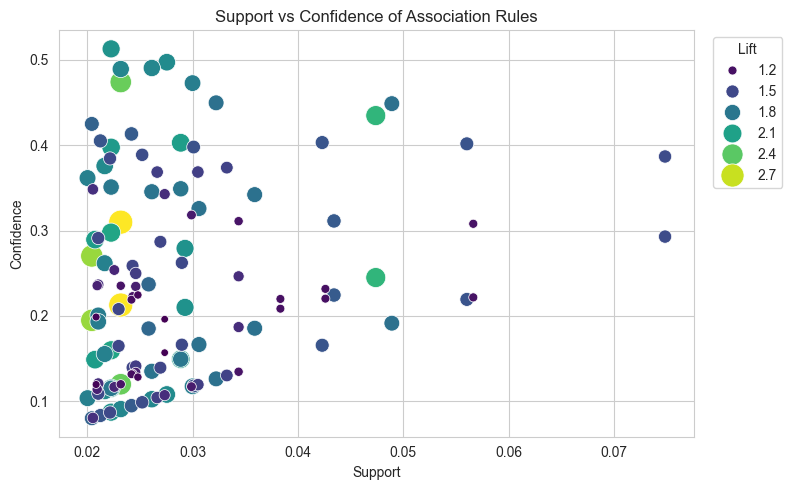

In [16]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', sizes=(30, 300))
plt.title('Support vs Confidence of Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.legend(title='Lift', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.tight_layout()
plt.show()

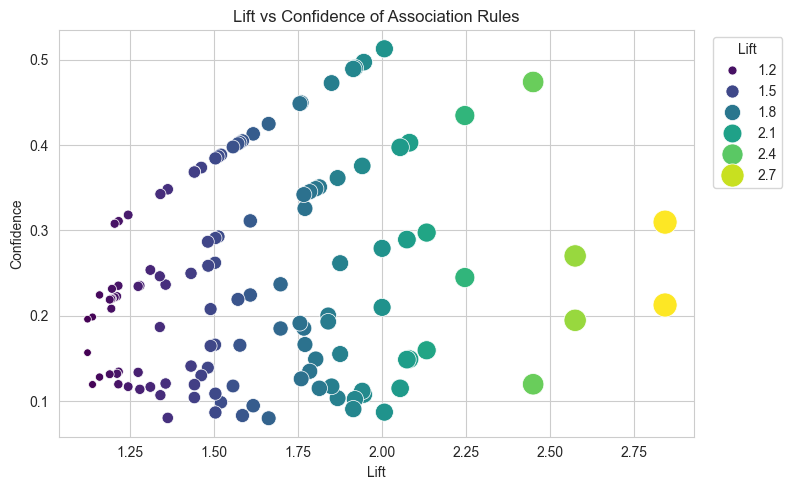

In [17]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=rules, x='lift', y='confidence', size='lift', hue='lift', palette='viridis', sizes=(30, 300))
plt.title('Lift vs Confidence of Association Rules')
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.grid(True)
plt.legend(title='Lift', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.tight_layout()
plt.show()

## Step 8. Business Analysis
- Rules such as `(whole milk, other vegetables) → (root vegetables)` and `(pip fruit) → (tropical fruit)` provide actionable insights for store layout, website layout, and promotions.
- High lift values suggest strong associations which can guide bundling decisions.
- Regular analysis of basket data is necessary to adapt to changing consumer preferences.
- The supermarket can use these insights to:
    - Optimize product placement in stores
    - Plan targeted promotions
    - Enhance cross-selling strategies
    - Improve inventory management by stocking frequently bought together items
    - Design marketing campaigns that highlight complementary products
    - Create personalized recommendations for customers based on their purchase history

# References
Hahsler, M., Chelluboina, S., Hornik, K., & Buchta, C. (2011). The arules R-Package Ecosystem: Analyzing Interesting Patterns from Large Transaction Datasets. Journal of Machine Learning Research, 12, 1977–1981.
